# 🏏 Cricket Player Segmentation using K-Means Clustering

## 1. Project Overview
**Objective:** To categorize cricket players into distinct segments (clusters) based on their batting performance statistics.

**Methodology:**
1.  **Data Cleaning:** Handling special characters and data types.

2.  **Scaling:** Normalizing data to ensure fair distance calculations.
3.  **K-Means Clustering:** Grouping players based on statistical similarity.
4.  **Profiling:** Interpreting the characteristics of each group.

In [20]:
# --- Step 1: Import Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Interactive Visualization
import plotly.express as px

## 2. Data Loading and Cleaning
We load the dataset and perform crucial cleaning steps. Specifically, the `HS` (Highest Score) column often contains an asterisk `*` denoting a "Not Out" innings. This must be removed to perform mathematical operations.

In [21]:
# Load the dataset
data = pd.read_csv('cricket clean.csv')
print("Dataset loaded. Shape:", data.shape)

# Display first few rows
data.head()

Dataset loaded. Shape: (79, 13)


,Player,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,exp
0,SR Tendulkar (INDIA),463,452,41,18426,200*,44.83,21367,86.23,49,96,20,23
1,KC Sangakkara (Asia/ICC/SL),404,380,41,14234,169,41.98,18048,78.86,25,93,15,15
2,RT Ponting (AUS/ICC),375,365,39,13704,164,42.03,17046,80.39,30,82,20,17
3,ST Jayasuriya (Asia/SL),445,433,18,13430,189,32.36,14725,91.20,28,68,34,22
4,DPMD Jayawardene (Asia/SL),448,418,39,12650,144,33.37,16020,78.96,19,77,28,17


In [22]:
# --- Data Cleaning ---

# 1. Clean the 'HS' (Highest Score) column
# The '*' indicates Not Out. We remove it to convert the column to integers.
data['HS'] = data['HS'].str.replace('*', '')
data['HS'] = data['HS'].astype(int)

# 2. Check for missing values
print("\n-------Missing Values-------\n", data.isnull().sum())

# 3. Check for duplicate values
print('\n\nNumber of duplicate values : ',data.duplicated().sum())


-------Missing Values-------
 Player    0
Mat       0
Inns      0
NO        0
Runs      0
HS        0
Ave       0
BF        0
SR        0
100       0
50        0
0         0
exp       0
dtype: int64


Number of duplicate values :  0


## 3. Feature Selection and Scaling
K-Means calculates the distance between points. If one feature has large numbers (e.g., Runs ~ 10,000) and another has small numbers (e.g., Average ~ 40), the large numbers will dominate the model.

**Solution:** We use `StandardScaler` to bring all features to the same scale (mean=0, std=1).

**Note:** We drop the `Player` name column as text cannot be mathematically clustered.

In [23]:
# Copy data to avoid modifying original dataframe during preprocessing
data_model = data.copy()

# Drop categorical columns
data_model.drop('Player', axis=1, inplace=True)

# Initialize Scaler
scaler = StandardScaler()

# Fit and Transform
data_scaled = scaler.fit_transform(data_model)

# Convert back to DataFrame for readability
data_scaled_df = pd.DataFrame(data_scaled, columns=data_model.columns)
data_scaled_df.head()

,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,exp
0,2.955282,3.169333,0.764963,4.262328,1.632443,1.072294,3.681214,0.703152,4.656726,3.050057,1.145837,2.812787
1,2.155179,2.138915,0.764963,2.609117,0.635224,0.587725,2.635385,-0.044139,1.671888,2.865418,0.296671,0.380938
2,1.761908,1.924245,0.625397,2.400099,0.474382,0.596226,2.319651,0.110997,2.293729,2.188406,1.145837,0.988900
3,2.711183,2.897417,-0.840046,2.292041,1.278591,-1.047909,1.588295,1.207091,2.044992,1.326755,3.523501,2.508806
4,2.751866,2.682747,0.625397,1.984430,-0.168986,-0.876185,1.996354,-0.034000,0.925678,1.880674,2.504502,0.988900


## 4. Finding the Optimal Number of Clusters (k)
We use two techniques to determine the best number of groups:
1.  **Elbow Method (SSD):** We look for the point where the decrease in error ("inertia") creates an "elbow" shape.
2.  **Silhouette Score:** Measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

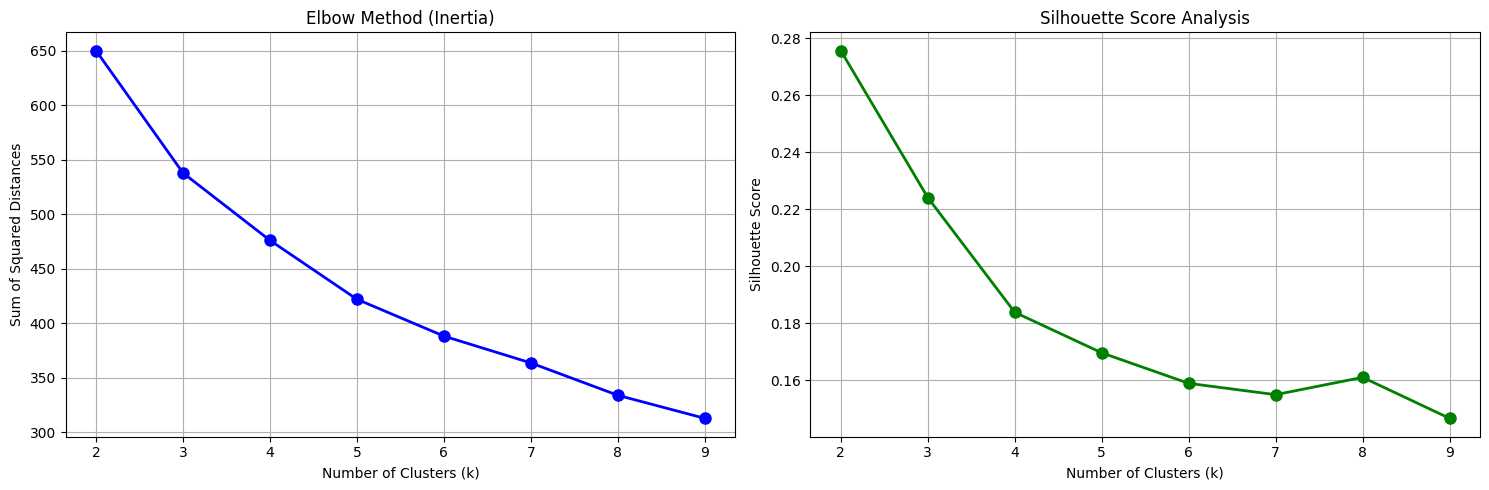

In [24]:
ssd = [] # Sum of Squared Distances (Inertia)
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    km = KMeans(n_clusters=k, max_iter=150, random_state=23)
    km.fit(data_scaled_df)

    # Append metrics
    ssd.append(km.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled_df, km.labels_))

# Create a figure with a specific size (Width, Height)
plt.figure(figsize=(15, 5))

# --- Plot 1: Elbow Method (SSD) ---
plt.subplot(1, 2, 1) # (1 Row, 2 Columns, Position 1)
plt.plot(k_range, ssd, 'o-', color='blue', linewidth=2, markersize=8)
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.grid(True)

# --- Plot 2: Silhouette Score ---
plt.subplot(1, 2, 2) # (1 Row, 2 Columns, Position 2)
plt.plot(k_range, silhouette_scores, 'o-', color='green', linewidth=2, markersize=8)
plt.title('Silhouette Score Analysis')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

**Analysis:** Based on the chart above, **k=4** provides a good balance. The SSD curve starts to flatten (the elbow), and the Silhouette score remains relatively healthy.

In [25]:
# --- Final Model Training ---

# Choose optimal K
optimal_k = 4

# Fit Model
kmeans = KMeans(n_clusters=optimal_k, max_iter=150, random_state=23)
kmeans.fit(data_scaled_df)

# Assign Labels back to original data
data['ClusterId'] = kmeans.labels_

print(f"K-Means Clustering complete with {optimal_k} clusters.")

K-Means Clustering complete with 4 clusters.


## 5. Cluster Interpretation & Profiling
Now that we have assigned clusters, we must understand *what* they represent. We will group the data by `ClusterId` and look at the average stats for each group.

In [26]:
# Calculate average metrics for each cluster
cluster_profile = data.groupby('ClusterId')[['Runs', 'Ave', 'SR', '100', 'Mat']].mean()

# Sort by Runs to see hierarchy
cluster_profile = cluster_profile.sort_values(by='Runs', ascending=False)
print(cluster_profile)

                   Runs        Ave         SR        100         Mat
ClusterId                                                           
1          13331.375000  39.701250  79.251250  23.750000  398.125000
2           9128.450000  40.887000  82.251500  16.500000  272.200000
3           6683.470588  32.687647  77.734706   5.588235  263.705882
0           5852.764706  39.773529  78.347059   8.764706  183.794118


### 🔍 Cluster Analysis (Example Interpretation)
Based on the output above, we can likely categorize the clusters as follows :

1.  **The Legends (High Runs, High Ave, High Matches):** These are experienced players who have scored heavily over many games (e.g., Tendulkar, Ponting).
2.  **Consistent Performers (Good Ave, Moderate Runs):** Reliable top/middle-order batters.
3.  **Aggressive Hitters (High Strike Rate):** Players who score fast but might have lower averages.
4.  **Early Career / Lower Order (Low Runs, Low Ave):** Players with fewer matches or those who bat lower down the order.

## 6. Visualization
We use an interactive 3D scatter plot to visualize the separation of players based on their Runs, Average, and Strike Rate.

In [27]:
# 3D Visualization using Plotly
fig = px.scatter_3d(data, x='Runs', y='Ave', z='SR', color='ClusterId', hover_name='Player',
    title='3D Visualization of Cricket Player Clusters',
    labels={'Ave': 'Batting Average', 'SR': 'Strike Rate'}
)

fig.update_layout(
    scene=dict(xaxis_title='Total Runs',yaxis_title='Batting Average',zaxis_title='Strike Rate'),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

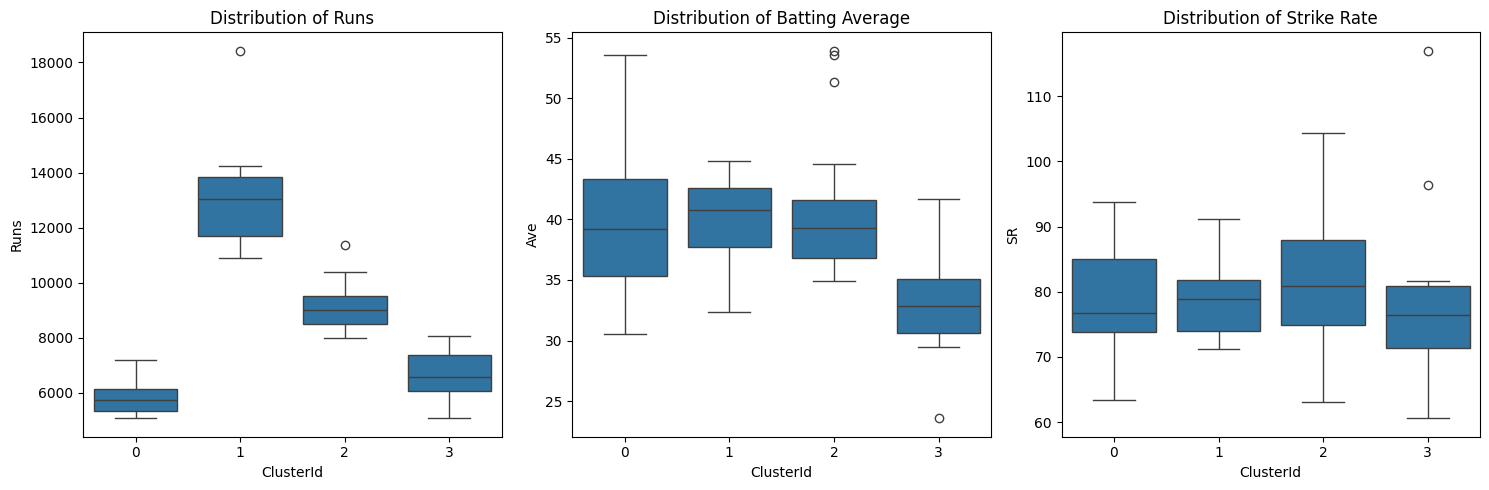

In [28]:
# 2D Boxplot Analysis for clearer distribution comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='ClusterId', y='Runs', data=data)
plt.title('Distribution of Runs')

plt.subplot(1, 3, 2)
sns.boxplot(x='ClusterId', y='Ave', data=data)
plt.title('Distribution of Batting Average')

plt.subplot(1, 3, 3)
sns.boxplot(x='ClusterId', y='SR', data=data)
plt.title('Distribution of Strike Rate')

plt.tight_layout()
plt.show()